# 期中考
* https://www.kaggle.com/c/ml100marathon-02-01

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler

DATA_ROOT = "data_midterm_example/"

In [2]:
dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [3]:
## 先用小量資料來測試
#dfoff = dfoff[:10000]
#dftest = dftest[:1000]

print(dfoff.shape)
print(dftest.shape)

(1160742, 7)
(306313, 6)


### 定義目標

In [4]:
## Create target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

### 定義新的 feature

In [5]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [6]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [7]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discount_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    df['Distance_type'] = df['Distance'].apply(lambda x : 1 if x > 2 else 0 )
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

In [8]:
# 店家發放優惠券次數
def CouponIndex(row):
    if np.isnan(row):
        return 0
    else:
        return 1
dfoff['CouponIndex'] = dfoff['Coupon_id'].apply(CouponIndex)
dftest['CouponIndex'] = dftest['Coupon_id'].apply(CouponIndex) 

dfoff_temp = dfoff[['Merchant_id','CouponIndex']]
dftest_temp = dftest[['Merchant_id','CouponIndex']]

dfoff_group = dfoff_temp.groupby('Merchant_id')
dftest_group = dftest_temp.groupby('Merchant_id')

dfoff_group_sum = dfoff_group.agg('sum').reset_index().rename(columns = {'CouponIndex':'Coupon_count'})
dftest_group_sum = dftest_group.agg('sum').reset_index().rename(columns = {'CouponIndex':'Coupon_count'})

dfoff = dfoff.merge(dfoff_group_sum, on = 'Merchant_id')
dftest = dftest.merge(dftest_group_sum, on = 'Merchant_id')

In [9]:
# User 獲得優惠券張數
def UserIndex(row):
    if np.isnan(row):
        return 0
    else:
        return 1
dfoff['UserIndex'] = dfoff['User_id'].apply(UserIndex)
dftest['UserIndex'] = dftest['User_id'].apply(UserIndex) 

dfoff_temp = dfoff[['User_id','UserIndex']]
dftest_temp = dftest[['User_id','UserIndex']]

dfoff_group = dfoff_temp.groupby('User_id')
dftest_group = dftest_temp.groupby('User_id')

dfoff_group_sum = dfoff_group.agg('sum').reset_index().rename(columns = {'UserIndex':'User_count'})
dftest_group_sum = dftest_group.agg('sum').reset_index().rename(columns = {'UserIndex':'User_count'})

dfoff = dfoff.merge(dfoff_group_sum, on = 'User_id')
dftest = dftest.merge(dftest_group_sum, on = 'User_id')

# 消費者的總購買次數
def UserIndex(row):
    if np.isnan(row):
        return 0
    else:
        return 1
dfoff['UserIndex'] = dfoff['User_id'].apply(UserIndex)
dftest['UserIndex'] = dftest['User_id'].apply(UserIndex)  

dfoff_temp = dfoff[['User_id','UserIndex']]
dftest_temp = dftest[['User_id','UserIndex']]

dfoff_group = dfoff_temp.groupby('User_id')
dftest_group = dftest_temp.groupby('User_id')

dfoff['UserCount'] = 0
dftest['UserCount'] = 0

def get_coupon_count(df,df_group):
    for i in range(len(df['User_id'])):
        df['UserCount'][i] = df_group.get_group(df['User_id'][i])['UserIndex'].sum()

get_coupon_count(dfoff,dfoff_group)
dfoff

In [10]:
# Check 相關係數
dfoff.corr()['label'].sort_values(ascending=False)

label            1.000000
CouponIndex      0.945769
discount_type    0.893634
discount_jian    0.526072
discount_man     0.506418
weekday_type     0.371477
Distance_type    0.313457
weekday_7        0.264702
Coupon_count     0.245070
weekday_5        0.244123
weekday_1        0.234004
weekday_6        0.225822
Distance         0.222471
weekday_4        0.209967
weekday_3        0.193491
weekday_2        0.190574
Date_received    0.090294
Coupon_id        0.014643
Date             0.011166
User_id         -0.000863
Merchant_id     -0.006524
weekday         -0.016272
discount_rate   -0.078597
User_count      -0.245648
UserIndex             NaN
Name: label, dtype: float64

### 將資料分為 train & valid 

In [11]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [12]:
original_feature = ['Distance_type',
                    'Coupon_count',
                    'User_count',
                    'Merchant_id',
                    'discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday', 
                    'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

18 ['Distance_type', 'Coupon_count', 'User_count', 'Merchant_id', 'discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [13]:
# 定義建模的 feature
predictors = original_feature
print(predictors)

['Distance_type', 'Coupon_count', 'User_count', 'Merchant_id', 'discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


### 建模 (function) : RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier


# 建立模型 (使用 20 顆樹，每棵樹最大深度 5)
clf_RF = RandomForestClassifier(n_estimators = 20,max_depth = 5)

# 訓練模型
clf_RF.fit(train[predictors], train['label'])

# 預測測試集
y_valid_RF_pred = clf_RF.predict_proba(valid[predictors])


validRF = valid.copy()
validRF['pred_prob'] = y_valid_RF_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_RF_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_RF_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.820, Accuracy: 0.952


### 建模 (function) : GradientBoosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# 建立模型 
clf_GDBT = GradientBoostingClassifier()

# 訓練模型
clf_GDBT.fit(train[predictors], train['label'])

# 預測測試集
y_valid_GDBT_pred = clf_GDBT.predict_proba(valid[predictors])


validGDBT = valid.copy()
validGDBT['pred_prob'] = y_valid_GDBT_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_GDBT_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_GDBT_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.851, Accuracy: 0.952


### 建模 (function) : Logistic Regression

In [16]:
from sklearn import linear_model

# 建立模型 
clf_LR = linear_model.LogisticRegression()

# 訓練模型
clf_LR.fit(train[predictors], train['label'])

# 預測測試集
y_valid_LR_pred = clf_LR.predict_proba(valid[predictors])


validLR = valid.copy()
validLR['pred_prob'] = y_valid_LR_pred[:, 1]
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_LR_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_LR_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

/Users/tomlong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Validation AUC: 0.798, Accuracy: 0.951


### 測試資料導入

In [17]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

# Random Forest
y_testRF_pred = clf_RF.predict_proba(testset[predictors])
testRF = testset.copy()
testRF['pred_prob'] = y_testRF_pred[:, 1]
# Gradient Boosting
y_testGDBT_pred = clf_GDBT.predict_proba(testset[predictors])
testGDBT = testset.copy()
testGDBT['pred_prob'] = y_testGDBT_pred[:, 1]
# Logistic Regression
y_testLR_pred = clf_LR.predict_proba(testset[predictors])
testLR = testset.copy()
testLR['pred_prob'] = y_testLR_pred[:, 1]

(306313, 24)


In [18]:
# Random Forest
outputRF = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], testRF["pred_prob"]), axis=1)
outputRF.loc[:, "User_id"] = outputRF["User_id"].apply(lambda x:str(int(x)))
outputRF.loc[:, "Coupon_id"] = outputRF["Coupon_id"].apply(lambda x:str(int(x)))
outputRF.loc[:, "Date_received"] = outputRF["Date_received"].apply(lambda x:str(int(x)))
outputRF["uid"] = outputRF[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
outputRF.reset_index(drop=True, inplace=True)
# Gradient Boosting
outputGDBT = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], testGDBT["pred_prob"]), axis=1)
outputGDBT.loc[:, "User_id"] = outputGDBT["User_id"].apply(lambda x:str(int(x)))
outputGDBT.loc[:, "Coupon_id"] = outputGDBT["Coupon_id"].apply(lambda x:str(int(x)))
outputGDBT.loc[:, "Date_received"] = outputGDBT["Date_received"].apply(lambda x:str(int(x)))
outputGDBT["uid"] = outputGDBT[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
outputGDBT.reset_index(drop=True, inplace=True)
# Logistic Regression
outputLR = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], testLR["pred_prob"]), axis=1)
outputLR.loc[:, "User_id"] = outputLR["User_id"].apply(lambda x:str(int(x)))
outputLR.loc[:, "Coupon_id"] = outputLR["Coupon_id"].apply(lambda x:str(int(x)))
outputLR.loc[:, "Date_received"] = outputLR["Date_received"].apply(lambda x:str(int(x)))
outputLR["uid"] = outputLR[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
outputLR.reset_index(drop=True, inplace=True)

In [19]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
# Random Forest
outRF = outputRF.groupby("uid", as_index=False).mean()
outRF = outRF[["uid", "pred_prob"]]
outRF.columns = ["uid", "label"]
outRF.to_csv("RF_Ver4.csv", header=["uid", "label"], index=False) # submission format
print(outRF.head())
# Gradient Boosting
outGDBT = outputGDBT.groupby("uid", as_index=False).mean()
outGDBT = outGDBT[["uid", "pred_prob"]]
outGDBT.columns = ["uid", "label"]
outGDBT.to_csv("GDBT_Ver4.csv", header=["uid", "label"], index=False) # submission format
print(outGDBT.head())
# Logistic Regression
outLR = outputLR.groupby("uid", as_index=False).mean()
outLR = outLR[["uid", "pred_prob"]]
outLR.columns = ["uid", "label"]
outRF.to_csv("LR_Ver4.csv", header=["uid", "label"], index=False) # submission format
print(outLR.head())

                     uid     label
0  1000020_2705_20160519  0.128122
1  1000020_8192_20160513  0.155207
2  1000065_1455_20160527  0.124422
3  1000085_8067_20160513  0.137338
4  1000086_2418_20160613  0.098876
                     uid     label
0  1000020_2705_20160519  0.062882
1  1000020_8192_20160513  0.084455
2  1000065_1455_20160527  0.053332
3  1000085_8067_20160513  0.071087
4  1000086_2418_20160613  0.018147
                     uid     label
0  1000020_2705_20160519  0.094315
1  1000020_8192_20160513  0.073461
2  1000065_1455_20160527  0.153976
3  1000085_8067_20160513  0.115597
4  1000086_2418_20160613  0.150307


### 試試看使用blending

In [20]:
### blending
# 三組模型分數
lr_score = 0.64144
gdbt_score = 0.63505
rf_score = 0.64144
sum_score = lr_score + gdbt_score + rf_score

y_testblending_pred = y_testLR_pred*lr_score/sum_score  + y_testGDBT_pred*gdbt_score/sum_score + y_testRF_pred*rf_score/sum_score
testblending = testset.copy()
testblending['pred_prob'] = y_testblending_pred[:, 1]

outputblending = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], testblending["pred_prob"]), axis=1)
outputblending.loc[:, "User_id"] = outputblending["User_id"].apply(lambda x:str(int(x)))
outputblending.loc[:, "Coupon_id"] = outputblending["Coupon_id"].apply(lambda x:str(int(x)))
outputblending.loc[:, "Date_received"] = outputblending["Date_received"].apply(lambda x:str(int(x)))
outputblending["uid"] = outputblending[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
outputblending.reset_index(drop=True, inplace=True)

outblending = outputblending.groupby("uid", as_index=False).mean()
outblending = outblending[["uid", "pred_prob"]]
outblending.columns = ["uid", "label"]
#outblending.to_csv("Blending(RF+LR+GDBT)_Ver3.csv", header=["uid", "label"], index=False) # submission format
print(outblending.head())

                     uid     label
0  1000020_2705_20160519  0.095214
1  1000020_8192_20160513  0.104441
2  1000065_1455_20160527  0.110767
3  1000085_8067_20160513  0.108130
4  1000086_2418_20160613  0.089347


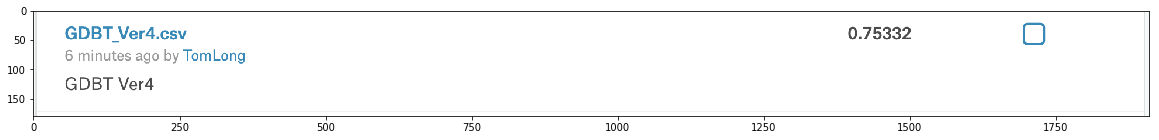

In [21]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


img = Image.open( "submission_MidtermD51-D53.png")
plt.figure(figsize=(20,12)) 
plt.imshow(img)
plt.show()